# Introduction

This notebook contains the code to fit TPCs for the growth curve data. The fitting has the follwong steps

## step 1) fit growth curves
Fit logistic growth curves to the data. First I fit with multistart and then use these estimates as the starting point for a bootstrapped estimates (removing indiividual data points). 

## step 2) fit TPCs
using the bootstraped estiamtes I fit TPC curves for each species/medium combination

## step 3) extract TPC parameters
using the TPC estimates I extract distributions of TPC parameters



In [1]:
library(MASS)
library(tidyverse)
library(nls.multstart)
library(broom)
# library(rTPC)
library(cowplot)
library(magick)

growth_data <- read_csv("../data//Nesbit.csv", col_types = cols()) %>% 
    mutate(Time = ifelse(str_detect(Citation,"Phillips"), Time / 24, Time)) %>%
    group_by(Temp,Species,Medium,Rep,Citation) %>%
    mutate(n = n()) %>%
    filter(n > 2) %>%
    nest() 

growth_data$id <- 1:nrow(growth_data)

growth_data <- unnest(growth_data, cols = data)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()

Linking to ImageMagick 7.1.0.20
Enabled features: fontconfig, freetype, ghostscript, heic, lcms, webp
Disabled features: cairo, fftw, pango, raw, rsvg, x11

Using 8 threads



In [2]:
growth_data %>%
    group_by(Citation) %>%
    summarise(`Number of TPCs` = n_distinct(paste(Rep,Medium,Species))) %>%
    filter(`Number of TPCs` > 1) %>%
    mutate(Citation = ifelse(Citation == "Smith_et_al", "Smith (unpublished)", Citation)) %>%
    write_csv("../docs/data/MetaAnalysis.csv")

In [3]:
#summary of data
print(paste("Species:",length(unique(growth_data$Species))))
print(paste("Studies:",length(unique(growth_data$Citation))))


[1] "Species: 105"
[1] "Studies: 21"


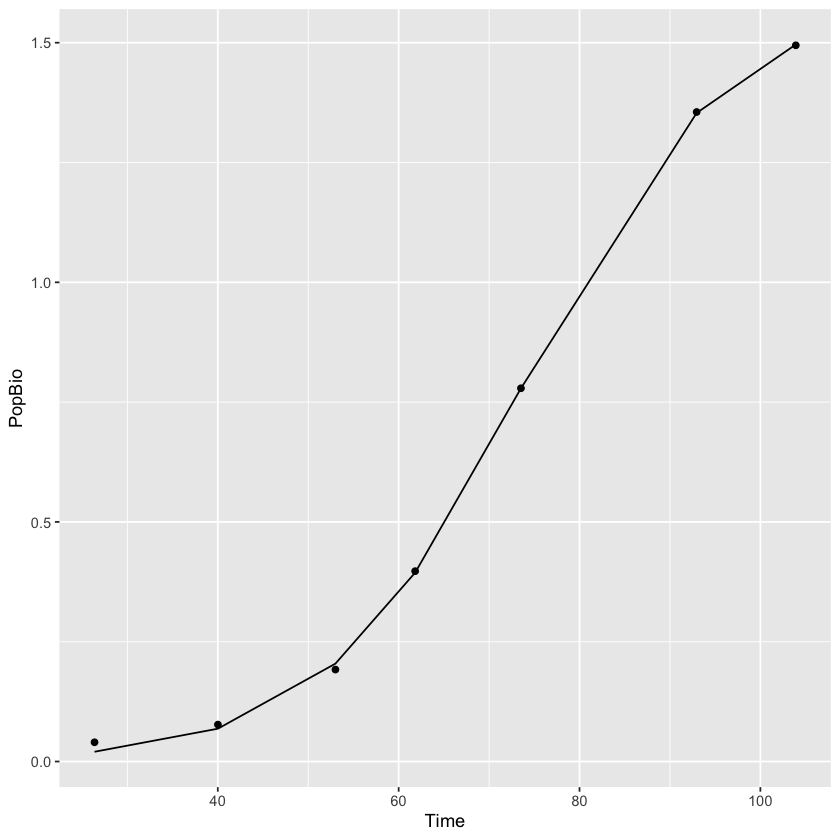

In [4]:
#fitting growth curves
logistic_growth <- function(N0,r,K,t){
    K / (1 + ((K - N0) / N0) * exp(-r * t))
}

#check single curve
df <- growth_data %>%
    filter(id == 247)
    

fit <- nls_multstart(PopBio ~ logistic_growth(N0,r,K,t=Time),
                     data = df,
                     iter = 250,
                     start_lower = c(N0=min(df$PopBio) / 10,r=0,K=max(df$PopBio) / 10),
                     start_upper = c(N0=min(df$PopBio) / 10,r=1,K=max(df$PopBio) / 10),
                     supp_errors = 'Y',
                     convergence_count = 100,
                     na.action = na.omit,
                     lower = c(N0=0,r=0,K=0))

preds <- augment(fit)

ggplot()+
    geom_point(aes(x = Time, y = PopBio), df)+
    geom_line(aes(x=Time, y = .fitted), preds)

In [5]:
#fit all curves - first multistart
grw_fits_multistart <- growth_data %>%
    group_by(Temp,Species,Medium,Rep,Citation,id,PopBio_unts)%>%
    nest() %>%
    mutate(fit = map(data , ~nls_multstart(PopBio ~ logistic_growth(N0,r,K,t=Time),
                     data = .x,
                     iter = 250,
                     start_lower = c(N0=0,r=0,K=1),
                     start_upper = c(N0=1,r=1,K=2),
                     supp_errors = 'Y',
                     convergence_count = 100,
                     na.action = na.omit,
                     lower = c(N0=0,r=0,K=0))))

grw_fits_multistart <- grw_fits_multistart %>%
    mutate(params = map(fit ,tidy), info = map(fit,glance)) %>%
    unnest(c(params, info)) %>%
    filter(isConv, p.value < 0.05) %>%
    dplyr::select(Temp,Species,Medium,Rep,Citation,id,term,estimate, PopBio_unts) %>%
    pivot_wider(names_from = term, values_from = estimate)

In [6]:
#to fit
grw_fits_multistart %>%
    dplyr::select(-N0) %>%
    pivot_longer(c(r,K),names_to = "param",values_to =  "value")%>%
    filter(!is.na(value)) %>%
    group_by(Species, Medium, Rep, Citation, param, PopBio_unts) %>%
    filter(n() > 3) %>%
    nest() %>% ungroup() %>% count(param)



param,n
<chr>,<int>
K,74
r,93


In [7]:
#TPC fitting
boltz <- function(temp,tref,r_tref,e){
    tref <- 273.15 + tref
    k <- 8.62e-05
    boltzmann.term <- r_tref * exp(e/k * ( (1/tref) - (1/(temp + 273.15)) ) )
    return(boltzmann.term)
}

#fit ss and boltz_curves
grw_TPC <- grw_fits_multistart %>%
    dplyr::select(-N0) %>%
    pivot_longer(c(r,K),names_to = "param",values_to =  "value")%>%
    filter(!is.na(value)) %>%
    group_by(Species, Medium, Rep, Citation, param, PopBio_unts) %>%
    filter(n() > 3) %>%
    nest() %>% ungroup %>%
    mutate(TPC_id = 1:n())  %>%
    mutate(fit_boltz = map(data, ~nls_multstart(value ~ boltz(temp = Temp, r_tref, e, tref = 20),
                         data = .x,
                         iter = 250,
                         start_lower = c(r_tref = 0, e = 0),
                         start_upper = c(r_tref = 1, e = 1),
                         supp_errors = 'Y',
                         convergence_count = 100,
                         na.action = na.omit,
                         lower = c(r_tref = 0, e = -5),
                         upper = c(r_tref = max(.x$value), e = 5))),
          fit_ss = map(data, ~nls_multstart(value ~ sharpeschoolhigh_1981(temp = Temp, r_tref, e ,eh, th, tref = 20),
                                            data = .x,
                                            iter = 250,
                                            start_lower = rTPC::get_start_vals(.x$Temp, .x$value, model_name = 'sharpeschoolhigh_1981') - 10,
                                            start_upper = rTPC::get_start_vals(.x$Temp, .x$value, model_name = 'sharpeschoolhigh_1981') + 10,
                                            supp_errors = "Y",
                                            convergence_count = 100,
                                            na.action = na.omit,
                                            lower = c(r_tref  = 0, e = 0 ,eh = 0, th = 0),
                                            upper = c(r_tref  = max(.x$value), e = 5 ,eh = 5, th = Inf))))



In [8]:
grw_TPC_selected <- grw_TPC

#remove null fits and non-converged, calculate AIC
grw_TPC_selected$boltz_AIC <- NA
grw_TPC_selected$ss_AIC <- NA

#loop over all fits
for(i in 1:nrow(grw_TPC_selected)){
    #testing boltzmann
    boltz_model <- grw_TPC_selected$fit_boltz[[i]]
    if(!is.null(boltz_model)){
        if(!boltz_model$convInfo$isConv){
            grw_TPC_selected$fit_boltz[i] <- NA
        } else {
            grw_TPC_selected$boltz_AIC[i] <- AIC(boltz_model)
        }
    } else {
        grw_TPC_selected$fit_boltz[i] <- NA
    }  
    
    #testing ss
    ss_model <- grw_TPC_selected$fit_ss[[i]]
    if(!is.null(ss_model)){
        if(!ss_model$convInfo$isConv){
            grw_TPC_selected$fit_ss[i] <- NA 
        } else {
            grw_TPC_selected$ss_AIC[i] <- AIC(ss_model)
        }
    } else {
        grw_TPC_selected$fit_ss[i] <- NA
    }  
}



In [9]:
#model selecting
grw_TPC_model_selected <- grw_TPC_selected %>%
    mutate(boltz_AIC = ifelse(is.na(boltz_AIC),Inf,boltz_AIC),
           ss_AIC = ifelse(is.na(ss_AIC),Inf,ss_AIC)) %>%
    mutate(best_model = case_when(boltz_AIC < ss_AIC ~ fit_boltz,
                                  boltz_AIC > ss_AIC ~ fit_ss)) %>%
    mutate(best_model_type = case_when(boltz_AIC < ss_AIC ~ "boltz",
                                  boltz_AIC > ss_AIC ~ "ss")) %>%
    dplyr::select(-fit_boltz, -fit_ss) %>%
    mutate(E = NA, B0 = NA)

for(i in 1:nrow(grw_TPC_model_selected)){
    best_model <- grw_TPC_model_selected$best_model[[i]]
    if(!is.null(best_model)){
        res = tidy(best_model)
        grw_TPC_model_selected$E[i] <- res %>% filter(term == "e") %>% pull(estimate)
        grw_TPC_model_selected$B0[i] <- res %>% filter(term == "r_tref") %>% pull(estimate)
    } else {   
    }
}

grw_TPC_final <- grw_TPC_model_selected %>%
    filter(!is.na(E))

In [10]:
#calculate a_parameter
a_data <- grw_TPC_final %>%
    dplyr::select(-boltz_AIC, -ss_AIC, -best_model, -data, -TPC_id) %>%
    group_by(Species,Medium,Rep,Citation,param,PopBio_unts) %>%
    nest() %>%
    pivot_wider(names_from = param, values_from = data) %>%
    unnest(c(r,K),names_sep = "_" ) %>%
    mutate(a_E = r_E - K_E, a_B0 = r_B0 / K_B0) %>%
    filter(!is.na(a_B0)) %>%            
    mutate(PopBio_units = case_when(PopBio_unts == "Absorbance (600nm) continuous" ~ "OD", 
                                    PopBio_unts == "Absorbance (660 nm)" ~ "OD",
                                    PopBio_unts == "OD_595" ~ "OD",
                                    PopBio_unts == "CFU" ~ "CFU",
                                    PopBio_unts == "CFU/g" ~ "CFU",
                                    PopBio_unts == "N" ~ "N")) %>%
    filter(!is.na(PopBio_units), PopBio_units != "N" ) %>%
    group_by(PopBio_units) %>%
    mutate(K_B0_norm = K_B0 / mean(K_B0), r_B0_norm = r_B0 / mean(r_B0), a_B0_norm = a_B0 / mean(a_B0))

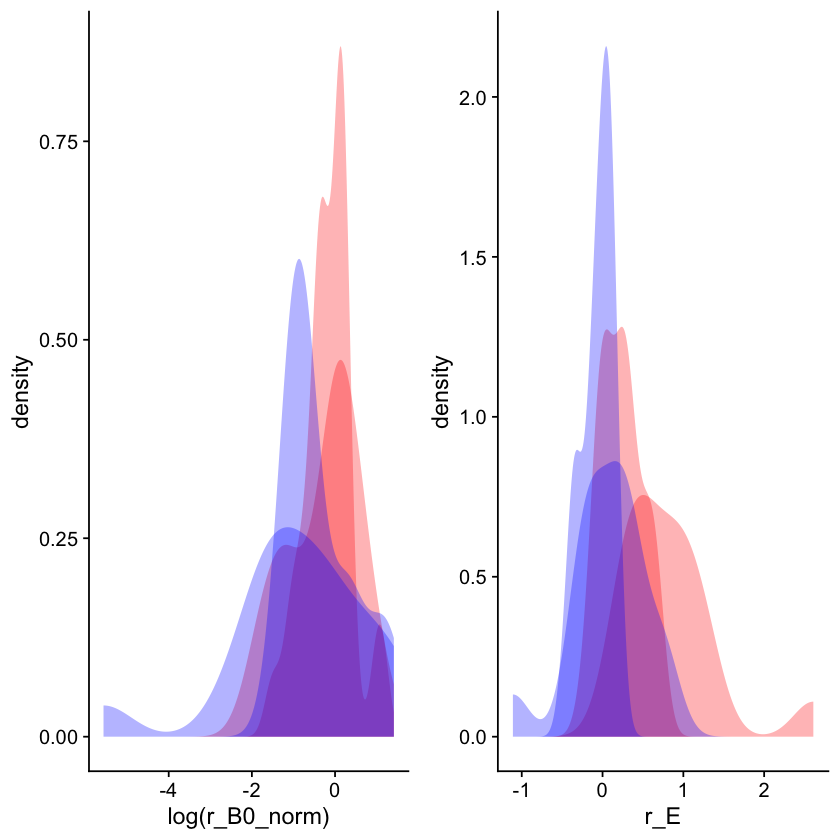

In [11]:
p1 <- a_data %>%
        ggplot()+
            geom_density(aes(x=log(r_B0_norm), group = PopBio_units), fill = "red", color = NA, alpha = 0.3)+
            geom_density(aes(x=log(K_B0_norm), group = PopBio_units), fill = "blue", color = NA, alpha = 0.3)+
            theme_cowplot()

p2 <- a_data %>%
        ggplot()+
            geom_density(aes(x=r_E, group = PopBio_units), fill = "red", color = NA, alpha = 0.3)+
            geom_density(aes(x=K_E, group = PopBio_units), fill = "blue", color = NA, alpha = 0.3)+
            theme_cowplot()

plot_grid(p1,p2)

In [25]:
K_data <- grw_TPC_final %>%
    dplyr::select(-boltz_AIC, -ss_AIC, -best_model, -data, -TPC_id) %>%
    group_by(Species,Medium,Rep,Citation,param,PopBio_unts) %>%
    nest() %>%
    pivot_wider(names_from = param, values_from = data) %>%
    unnest(c(r,K),names_sep = "_" ) %>%
    filter(!is.na(K_E), !is.na(K_B0)) %>%
    mutate(PopBio_units = case_when(PopBio_unts == "Absorbance (600nm) continuous" ~ "OD", 
                                        PopBio_unts == "Absorbance (660 nm)" ~ "OD",
                                        PopBio_unts == "OD_595" ~ "OD",
                                        PopBio_unts == "CFU" ~ "CFU",
                                        PopBio_unts == "CFU/g" ~ "CFU",
                                        PopBio_unts == "N" ~ "N")) %>%
    filter(!is.na(PopBio_units), PopBio_units != "N") %>%
    group_by(Citation) %>%
    mutate(K_B0_norm = K_B0 / mean(K_B0), r_B0_norm = r_B0 / mean(r_B0, na.rm = T))

write_csv(K_data,"..//data/K_data.csv")

Warning message:
“Removed 24 rows containing missing values (geom_point).”


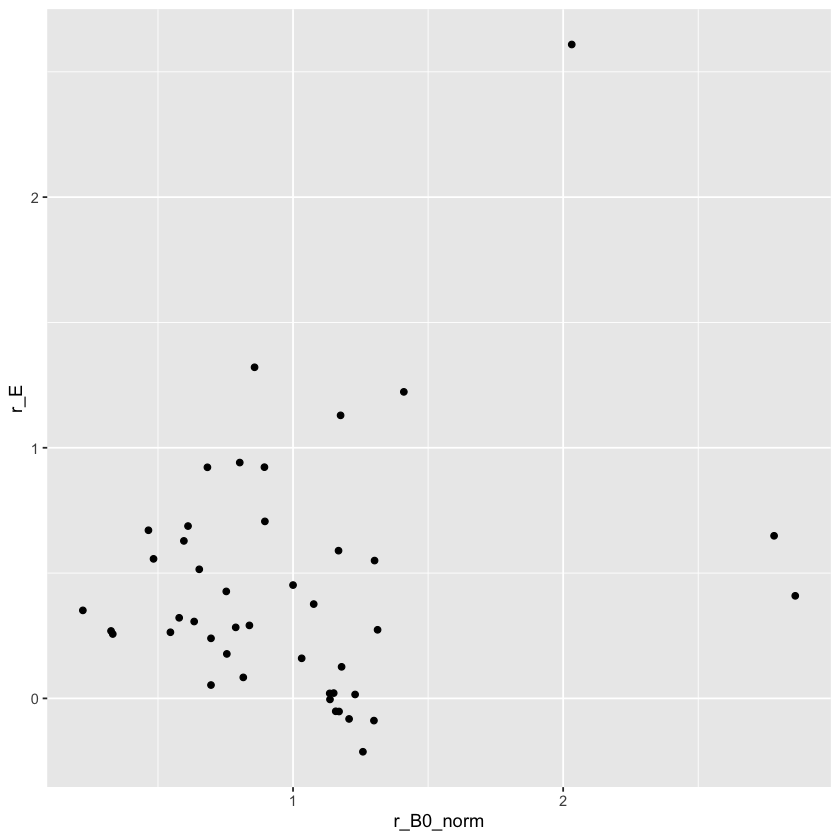

In [29]:
qplot(data = K_data, r_B0_norm, r_E, geom = "point")

# K_data %>% pull(r_B0_norm)

In [13]:
K_B0_fit <- K_data %>%
    mutate(K_B0_norm = log(K_B0_norm)) %>%
    pull(K_B0_norm) %>%
    fitdistr(. , densfun =
             "normal")

K_E_fit <- K_data %>%
    filter(abs(K_E) < 2 ) %>%
    pull(K_E) %>%
    fitdistr(. , densfun = "normal")

K_B0_fit$estimate
K_B0_fit$sd

mean         sd 
-0.1367406  0.5584094

mean         sd 
0.06771709 0.04788321

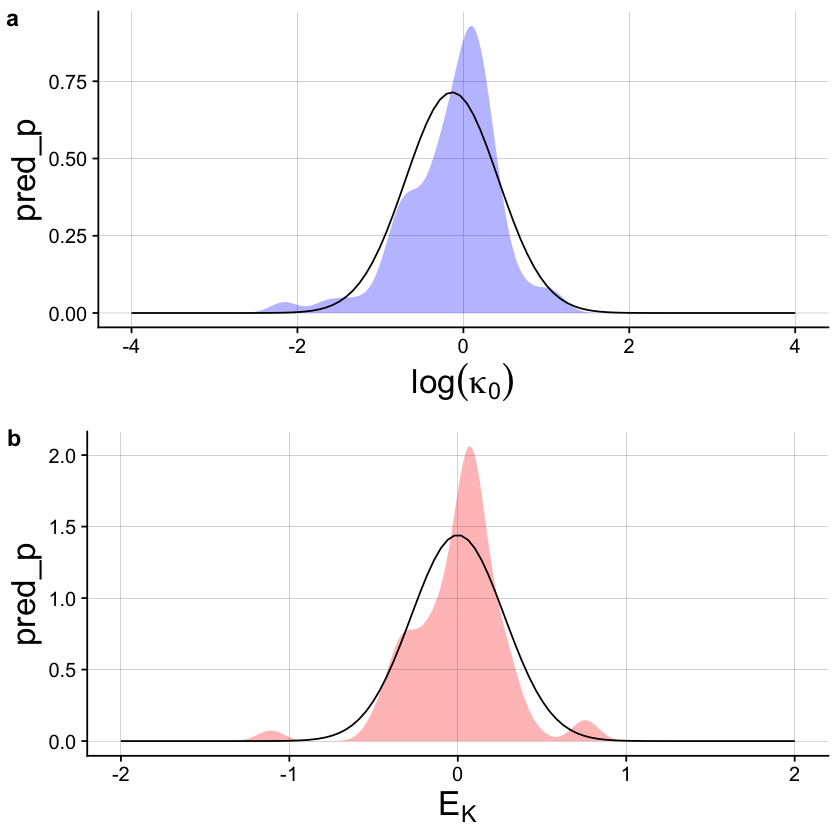

In [14]:
x <- seq(-4,4, length.out = 100)
pred_p <- dnorm(x, K_B0_fit$estimate["mean"], K_B0_fit$estimate["sd"])

p1 <- K_data %>%
    ggplot()+
      geom_density(aes(x=log(K_B0_norm)), fill = "blue", color = NA, alpha = 0.3)+
geom_line(data = data.frame(x,pred_p), aes(x,pred_p))  +
    theme_cowplot()+
    theme(panel.grid.major = element_line(size = 0.05),
             axis.text = element_text(size = 12),
             axis.title = element_text(size = 20)) +
    xlab(expression(paste(log(kappa[0]))))

x <- seq(-2,2, length.out = 100)
pred_p <- dnorm(x, K_E_fit$estimate["mean"], K_E_fit$estimate["sd"])

p2 <- K_data %>%
    filter(abs(K_E) < 2 ) %>%
    ggplot()+
      geom_density(aes(x=K_E), fill = "red", color = NA, alpha = 0.3)+
geom_line(data = data.frame(x,pred_p), aes(x,pred_p))  +
    theme_cowplot()+
    theme(panel.grid.major = element_line(size = 0.05),
             axis.text = element_text(size = 12),
             axis.title = element_text(size = 20))+
    xlab(expression(paste(E[K])))


p <- plot_grid(p1,p2, nrow = 2,labels = c("a","b"))

p

ggsave("../docs//Figures/K_TPC_distribution.pdf", p, width = 5, height = 5)

In [15]:
data.frame(K0 =K_B0_fit$estimate, E_K = K_E_fit$estimate) %>%
    rownames_to_column(var = "moment") %>%
    pivot_longer(-moment,  names_to = "param",values_to = "value") %>%
    write_csv("../data/K_TPC_output.csv")

In [16]:
data.frame(K0 =K_B0_fit$estimate, E_K = K_E_fit$estimate) %>%
    rownames_to_column(var = "moment") %>%
    pivot_longer(-moment,  names_to = "param",values_to = "value")

moment,param,value
<chr>,<chr>,<dbl>
mean,K0,-0.1367405909
mean,E_K,0.0001314089
sd,K0,0.5584094159
sd,E_K,0.2768394986


In [17]:
K_B0_fit

      mean           sd     
  -0.13674059    0.55840942 
 ( 0.06771709) ( 0.04788321)

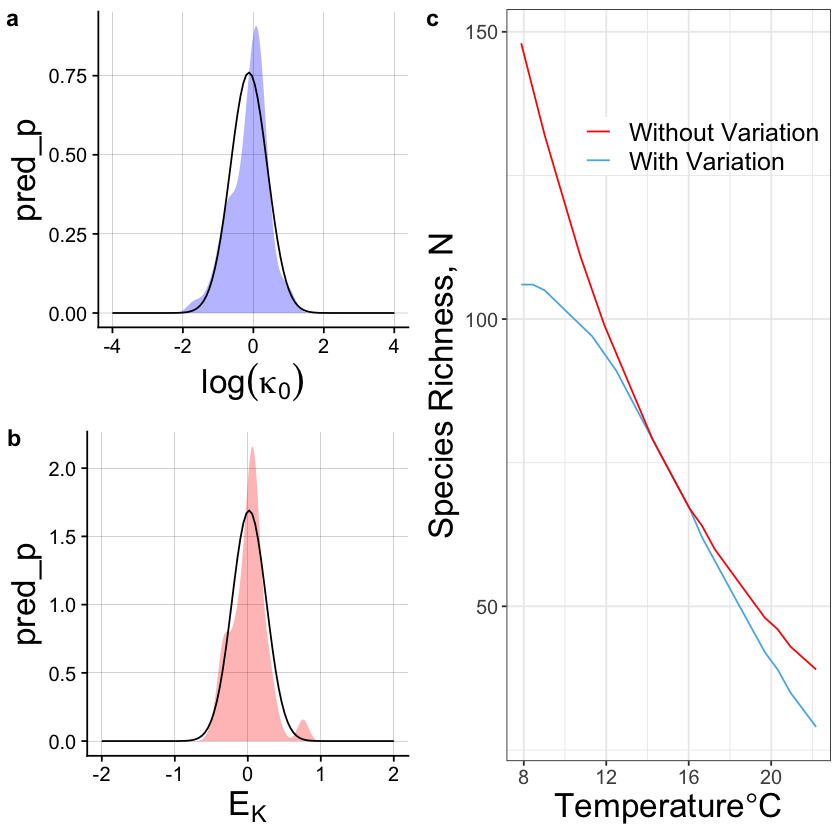

In [18]:
cols <- c("Without Variation" =  "red", "With Variation" = "#56B4E9")

DT_to_T <- function(T, Tref){
    return( (1 / (((8.617e-5) * T) + (1/Tref))) - 273.15)
}

p_MTE <- read_csv("./HelperScripts/Data/Non_assembly/sp_num_MTE.csv", col_names = c("Without Variation","With Variation"), col_types = cols()) %>%
     mutate(T = seq(-1,1,length.out = 25)) %>%
    pivot_longer(-T) %>%
    mutate(T = DT_to_T(T, 288)) %>%
    ggplot(aes(x=T, y = value, group = name, color = name))+
    geom_line()+
    scale_color_manual(values = cols, name = "")+
        xlab(expression(Temperature  *degree*C)) + ylab("Species Richness, N")+
        theme_bw()+
            theme(strip.background = element_blank(),
              strip.text = element_blank(),
              legend.position = c(0.6,0.85),
              legend.text = element_text(size = 15),
              legend.title = element_text(size = 20),
                  legend.background = element_blank(),
             axis.text = element_text(size = 12),
             axis.title = element_text(size = 20))


p_comb_final <- plot_grid(p,p_MTE, nrow = 1,labels = c("","c"))
ggsave("../docs//Figures/MTE_fig.pdf", p_comb_final, width = 7, height = 4)

p_comb_final


In [31]:
K_B0_fit <- K_data %>%
    mutate(K_B0_norm = log(K_B0_norm)) %>%
    pull(K_B0_norm) %>%
    fitdistr(. , densfun =
             "normal")

K_E_fit <- K_data %>%
    filter(abs(K_E) < 2 ) %>%
    pull(K_E) %>%
    fitdistr(. , densfun = "normal")

K_B0_fit$estimate
K_B0_fit$sd

mean         sd 
-0.1269588  0.5248639

mean         sd 
0.06460628 0.04568354